# CS109A Alzheimer's Disease Project EDA
December 12, 2018

- Tatyana Zyabkina
- Joanna Guo
- John Liang
- Ray Ortigas

This notebook contains a preliminary EDA looking at data provided by ADNI (Alzheimer's Disease Neuroimaging Initiative).

## Styling

In [44]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Imports

In [45]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load ADNIMARGE

For the preliminary EDA we will examine ADNIMERGE.csv, which contains some of the key variables in one table.

In [46]:
adni_df = pd.read_csv("../data/ADNIMERGE.csv")

In [47]:
adni_df.shape

(13017, 94)

In [48]:
def unique_patient_dx():
    adni_df = pd.read_csv("../data/ADNIMERGE.csv")
    ad_mo = adni_df[adni_df.DX == 'Dementia'].groupby(by = ['RID'])['Month'].min()
    ad_rid = adni_df[adni_df.DX == 'Dementia']['RID'].unique()
    patient = adni_df[adni_df.VISCODE == 'bl']
    patient['AD_any'] = patient.RID.isin(ad_rid)
    patient = patient.join(ad_mo, how = 'left', on = 'RID', rsuffix='_AD')
    return patient

## ApoE4 Exploration

In [86]:
# create a table with single record per patient

patient = unique_patient_dx()
# look at the APOE 4 allele data

patient['APOE4'].unique()

array([  0.,   1.,   2.,  nan])

In [51]:
# Summary 

summary_count = patient.groupby(['APOE4', 'AD_any']).agg({'RID': 'count'})
APOE_pcts = summary_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
APOE_pcts

RID
APOE4 AD_any           
0.0   False   74.126638
      True    25.873362
1.0   False   47.648903
      True    52.351097
2.0   False   32.748538
      True    67.251462

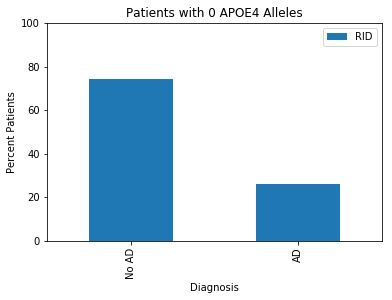

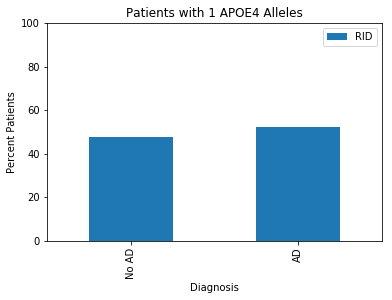

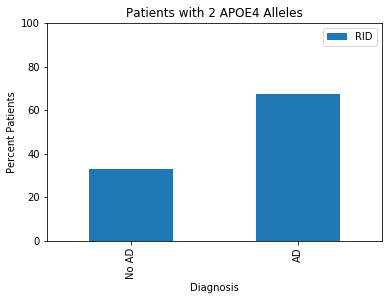

In [52]:
# Chart to visually present the breakdown by APOE type

for i in range(3):
    ax = APOE_pcts[APOE_pcts.index.get_level_values(0)==i].plot.bar()
    ax.set_xticklabels(['No AD', 'AD'])
    ax.set_ylim(0, 100)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Percent Patients')
    ax.set_title('Patients with {} APOE4 Alleles'.format(i))

### TOMM40 Genotype and AD

In [53]:
## LOAD TOMM40 DATA

tomm40 = pd.read_csv('../data/TOMM40.csv')
tomm40.head()

,PTID,RID,TOMM40_A1,TOMM40_A2,update_stamp
0,002_S_0295,295,16.0,21.0,2011-04-25 18:14:08.0
1,002_S_0413,413,16.0,34.0,2011-04-25 18:14:08.0
2,002_S_0559,559,35.0,35.0,2011-04-25 18:14:08.0
3,002_S_0619,619,28.0,28.0,2011-04-25 18:14:08.0
4,002_S_0685,685,33.0,34.0,2011-04-25 18:14:08.0


In [54]:
tomm40.shape

(757, 5)

In [55]:
# Join TOMM40 data to the patient file
tomm40_dx = pd.merge(tomm40, patient[['PTID', 'RID','AD_any', 'Month_AD']], left_on = 'RID', right_on = 'RID', how = 'inner')
tomm40_dx.head()

,PTID_x,RID,TOMM40_A1,TOMM40_A2,update_stamp,PTID_y,AD_any,Month_AD
0,002_S_0295,295,16.0,21.0,2011-04-25 18:14:08.0,002_S_0295,False,NaN
1,002_S_0413,413,16.0,34.0,2011-04-25 18:14:08.0,002_S_0413,False,NaN
2,002_S_0559,559,35.0,35.0,2011-04-25 18:14:08.0,002_S_0559,False,NaN
3,002_S_0619,619,28.0,28.0,2011-04-25 18:14:08.0,002_S_0619,True,0.0
4,002_S_0685,685,33.0,34.0,2011-04-25 18:14:08.0,002_S_0685,False,NaN


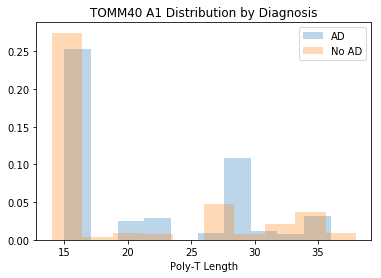

In [58]:
ad_a1 = tomm40_dx[tomm40_dx['AD_any']]['TOMM40_A1'][tomm40_dx[tomm40_dx['AD_any']]['TOMM40_A1'].notnull()]
noad_a1 = tomm40_dx[tomm40_dx['AD_any']==False]['TOMM40_A1'][tomm40_dx[tomm40_dx['AD_any']==False]['TOMM40_A1'].notnull()]
plt.hist(ad_a1, alpha = 0.3, density = True, label = 'AD')
plt.hist(noad_a1, alpha = 0.3, density = True, label = 'No AD')
plt.legend()
plt.xlabel('Poly-T Length')
plt.title('TOMM40 A1 Distribution by Diagnosis');

Long poly-T lengths were associated with late onset AD among those with most common ε3 APOE allele. From the chart above we can observe that for those with diagnosed with AD, there is a higher proportion of people with a A1 allele length of more than 25 T repeats.

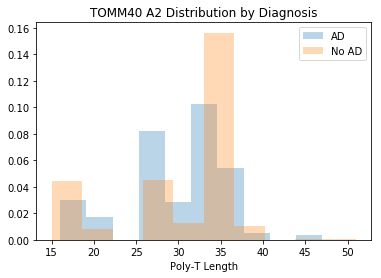

In [59]:
ad_a1 = tomm40_dx[tomm40_dx['AD_any']]['TOMM40_A2'][tomm40_dx[tomm40_dx['AD_any']]['TOMM40_A2'].notnull()]
noad_a1 = tomm40_dx[tomm40_dx['AD_any']==False]['TOMM40_A2'][tomm40_dx[tomm40_dx['AD_any']==False]['TOMM40_A2'].notnull()]
plt.hist(ad_a1, alpha = 0.3, density = True, label = 'AD')
plt.hist(noad_a1, alpha = 0.3, density = True, label = 'No AD')
plt.legend()
plt.xlabel('Poly-T Length')
plt.title('TOMM40 A2 Distribution by Diagnosis');

### RNA Microarray Data

In [60]:
# to convert all gene columns to float, export, then import
#pat_genes.to_csv('../data/all_genes_transposed.csv')

# load and process gene name index file
gene_ind = pd.read_csv("../data/Gene_expression_index.csv", index_col = 'index')
gene_ind.index = gene_ind.index.astype('str') 

pat_genes1 = pd.read_csv('../data/all_genes_transposed.csv', index_col='Unnamed: 0')

In [62]:
pat_genes1.columns = pat_genes1.columns.astype('str') 

In [63]:
pat_genes1.columns

Index(['phase', 'VISCODE', 'PTID', '260/280', '260/230', 'RIN', 'Affy Plate',
       'YearofCollection', '1', '2',
       ...
       '49380', '49381', '49382', '49383', '49384', '49385', '49386', 'RID',
       'AD_any', 'Month_AD'],
      dtype='object', length=49397)

In [64]:
pat_genes1['AD_any'].value_counts()

False    529
True     215
Name: AD_any, dtype: int64

In [65]:
gene_ind.head()

,ProbeSet,LocusLink,Symbol
index,,,
1,11715100_at,LOC8355,HIST1H3G
2,11715101_s_at,LOC8355,HIST1H3G
3,11715102_x_at,LOC8355,HIST1H3G
4,11715103_x_at,LOC126282,TNFAIP8L1
5,11715104_s_at,LOC92736,OTOP2


In [66]:
mean = pat_genes1.drop(['RID', 'Month_AD', 'YearofCollection'], axis = 1).groupby(['AD_any']).agg('mean').transpose()
var = pat_genes1.drop(['RID', 'Month_AD', 'YearofCollection'], axis = 1).groupby(['AD_any']).agg('var').transpose()

In [68]:
gene_means = gene_ind.join(mean, how = 'inner')
gene_means = gene_means.join(var, how = 'inner',  lsuffix='_mean', rsuffix='_var')

In [43]:
gene_means.head()

,ProbeSet,LocusLink,Symbol,False_mean,True_mean,False_var,True_var
1,11715100_at,LOC8355,HIST1H3G,2.418318,2.422465,0.039466,0.037855
2,11715101_s_at,LOC8355,HIST1H3G,2.442100,2.453060,0.052385,0.047083
3,11715102_x_at,LOC8355,HIST1H3G,2.032457,2.042353,0.031818,0.030819
4,11715103_x_at,LOC126282,TNFAIP8L1,3.567664,3.560767,0.092021,0.099353
5,11715104_s_at,LOC92736,OTOP2,2.290786,2.292986,0.026649,0.025547


In [71]:
gene_means['diff'] = gene_means.True_mean - gene_means.False_mean
gene_means['diff_std'] = np.sqrt(gene_means.False_var/pat_genes1['AD_any'].value_counts()[0] + gene_means.True_var/pat_genes1['AD_any'].value_counts()[1])
gene_means['t_score'] = np.abs(gene_means['diff'])/gene_means['diff_std']

### Genes mentioned in the literature

In [85]:
ref_results = gene_means[gene_means.Symbol.isin(['ABCA7', 'MS4A6A', 'MS4A4E', 'EPHA1', 'CD33', 
                                                 'CD2AP', 'CR1', 'CLU', 'BIN1', 'PICALM'])]
ref_results

,ProbeSet,LocusLink,Symbol,False_mean,True_mean,False_var,True_var,diff,diff_std,t_score,std_diff
752,11715851_s_at,LOC1191,CLU,3.603888,3.604888,0.232341,0.211790,0.001000,0.037740,0.026495,0.954752
1747,11716846_a_at,LOC64231,MS4A6A,10.453051,10.506181,0.052240,0.048863,0.053130,0.018056,2.942512,0.967140
4532,11719631_s_at,LOC274,BIN1,10.218176,10.181498,0.066621,0.057589,-0.036678,0.019844,1.848304,0.929743
4810,11719909_s_at,LOC8301,PICALM,7.444168,7.505586,0.130809,0.120210,0.061418,0.028397,2.162824,0.958631
4811,11719910_a_at,LOC8301,PICALM,10.191151,10.219535,0.048408,0.053012,0.028384,0.018387,1.543697,1.046478
8274,11723373_a_at,LOC2041,EPHA1,4.716879,4.704526,0.172294,0.176620,-0.012353,0.033870,0.364729,1.012477
8750,11723849_a_at,LOC64231,MS4A6A,9.412533,9.474014,0.127903,0.125510,0.061481,0.028732,2.139775,0.990602
8934,11724033_s_at,LOC23607,CD2AP,7.024234,6.883814,0.713603,0.737287,-0.140420,0.069125,2.031411,1.016460
8935,11724034_at,LOC23607,CD2AP,5.570701,5.501084,0.209158,0.276445,-0.069618,0.041002,1.697903,1.149655
8936,11724035_at,LOC23607,CD2AP,2.408144,2.433442,0.040439,0.041396,0.025298,0.016401,1.542506,1.011763


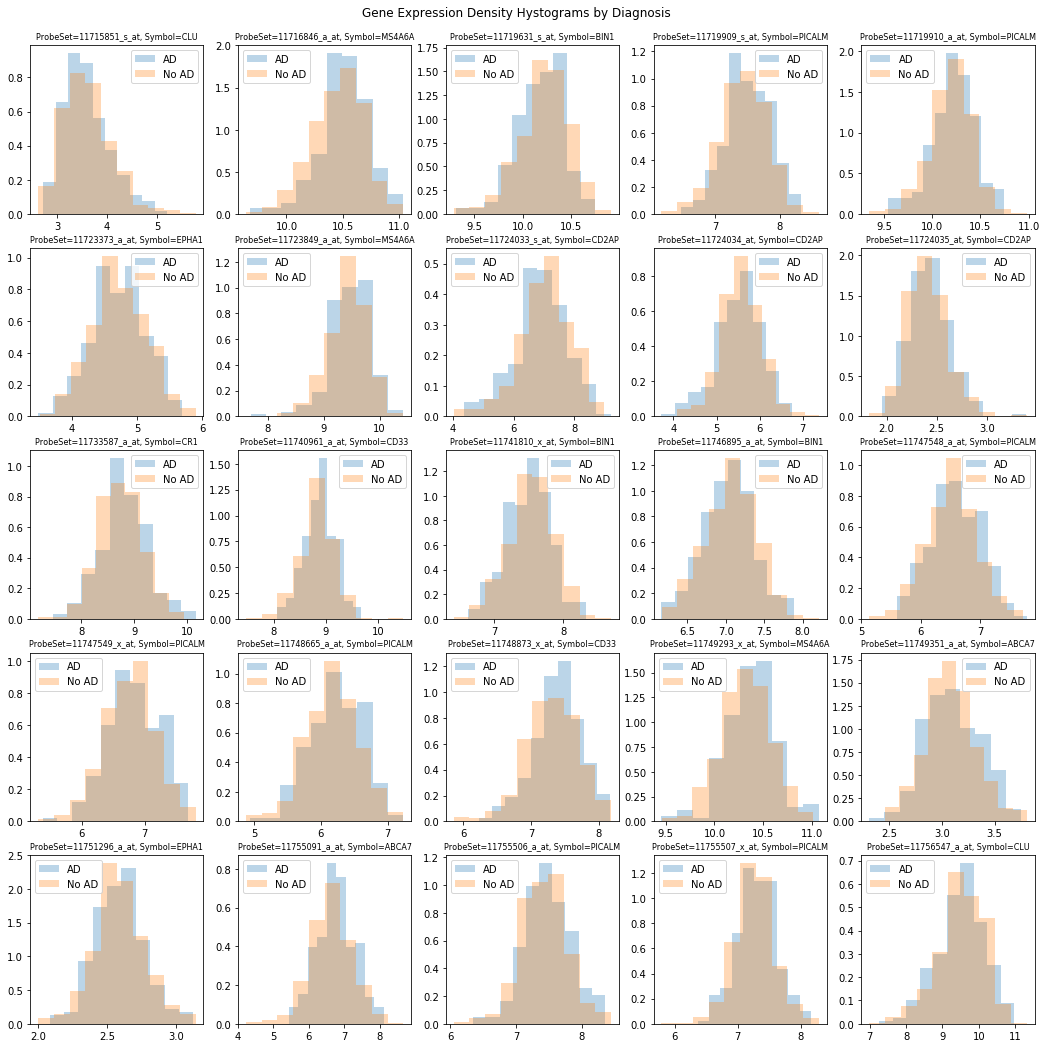

In [84]:
fig, axs = plt.subplots(5,5, figsize = (18,18))
fig.suptitle('Gene Expression Density Hystograms by Diagnosis', y = 0.91)
for i, ax in enumerate(axs.ravel()):
    ax.hist(pat_genes1[pat_genes1['AD_any']][ref_results.index[i]], alpha = 0.3, density = True, label = 'AD')
    ax.hist(pat_genes1[pat_genes1['AD_any']==False][ref_results.index[i]], alpha = 0.3, density = True, label = 'No AD')
    ax.set_title('ProbeSet={}, Symbol={}'.format(ref_results['ProbeSet'][ref_results.index[i]],
                ref_results['Symbol'][ref_results.index[i]]), fontsize = 8)
    ax.legend()

### Genes with the Largest Difference between Means and Variance

In [90]:
sig_genes = gene_means[gene_means['t_score']>5]

In [91]:
# note that gene MARC1 was labeled 1-Mar in the original data.
sig_genes.Symbol.replace(to_replace = '1-Mar', value = 'MARC1', inplace=True)
sig_genes

,ProbeSet,LocusLink,Symbol,False_mean,True_mean,False_var,True_var,diff,diff_std,t_score,std_diff
3308,11718407_a_at,LOC7009,TMBIM6,10.750635,10.812237,0.021280,0.018298,0.061602,0.011195,5.502475,0.927309
4203,11719302_a_at,LOC5836,PYGL,10.299535,10.427302,0.105805,0.082318,0.127767,0.024143,5.292104,0.882055
4381,11719480_a_at,LOC1475,CSTA,10.945331,11.047158,0.077256,0.047931,0.101827,0.019209,5.301100,0.787665
11484,11726583_s_at,LOC10970,CKAP4,10.361824,10.476456,0.076474,0.066306,0.114632,0.021283,5.386077,0.931148
13711,11728810_a_at,LOC79746,ECHDC3,5.551469,5.790763,0.350896,0.313129,0.239294,0.046041,5.197462,0.944653
16478,11731577_a_at,LOC6580,SLC22A1,6.426066,6.723144,0.546331,0.398996,0.297078,0.053745,5.527517,0.854586
16679,11731778_a_at,LOC64757,MARC1,8.000922,8.199567,0.265960,0.213427,0.198645,0.038671,5.136800,0.895810
31790,11746889_a_at,LOC10970,CKAP4,6.734922,6.916921,0.209646,0.186775,0.181998,0.035567,5.117032,0.943878
32056,11747155_s_at,LOC53826,FXYD6,4.617622,4.821177,0.260835,0.223847,0.203555,0.039169,5.196813,0.926388
38066,11753165_a_at,LOC5873,RAB27A,8.711078,8.861819,0.129715,0.117481,0.150741,0.028136,5.357604,0.951674


CKAP4 is found to have a significant difference in two probe sets, suggesting that the difference means for this gene is consistent.

A large difference in the variance of the gene expression may suggest that there is a presence of an AD subtype that is driven by the outliers or rare mutations. We found three genes with a large difference in the standard deviation. 

In [89]:
gene_means['std_diff'] = np.sqrt(gene_means['True_var'])/np.sqrt(gene_means['False_var'])

std_change = pd.concat([gene_means[gene_means['std_diff']>2.5], gene_means[gene_means['std_diff']<0.4]])
std_change

,ProbeSet,LocusLink,Symbol,False_mean,True_mean,False_var,True_var,diff,diff_std,t_score,std_diff
9989,11725088_at,LOC4619,MYH1,1.906482,1.935470,0.011982,0.193429,0.028988,0.030370,0.954495,4.017856
21323,11736422_s_at,LOC10631,POSTN,2.118631,2.134526,0.018120,0.115872,0.015894,0.023941,0.663879,2.528792
49186,11764285_at,NaN,NaN,2.168304,2.159740,0.117581,0.016761,-0.008565,0.017327,0.494303,0.377551


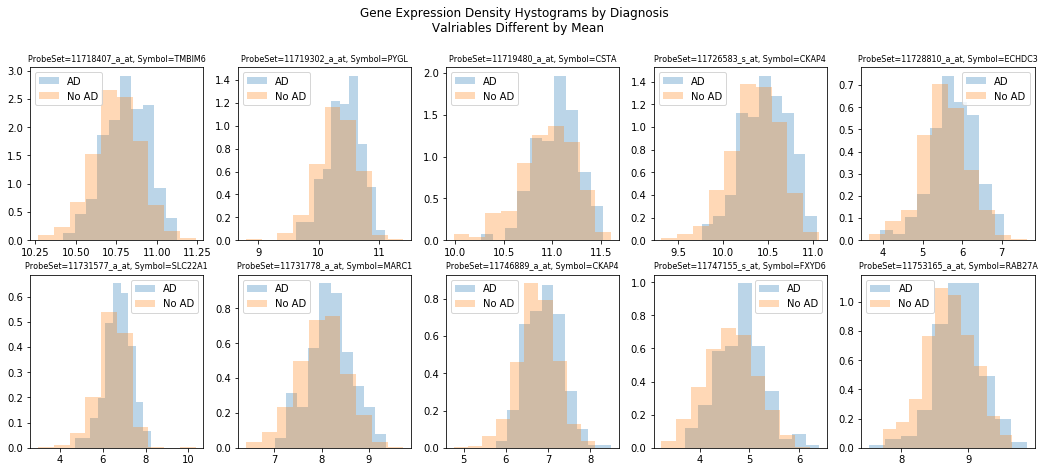

In [92]:
fig, axs = plt.subplots(2,5, figsize = (18,7))
fig.suptitle('Gene Expression Density Hystograms by Diagnosis \n Valriables Different by Mean', y = 1)
for i, ax in enumerate(axs.ravel()):
    ax.hist(pat_genes1[pat_genes1['AD_any']][sig_genes.index[i]], alpha = 0.3, density = True, label = 'AD')
    ax.hist(pat_genes1[pat_genes1['AD_any']==False][sig_genes.index[i]], alpha = 0.3, density = True, label = 'No AD')
    ax.set_title('ProbeSet={}, Symbol={}'.format(sig_genes['ProbeSet'][i],
                sig_genes['Symbol'][i]), fontsize = 8)
    ax.legend()

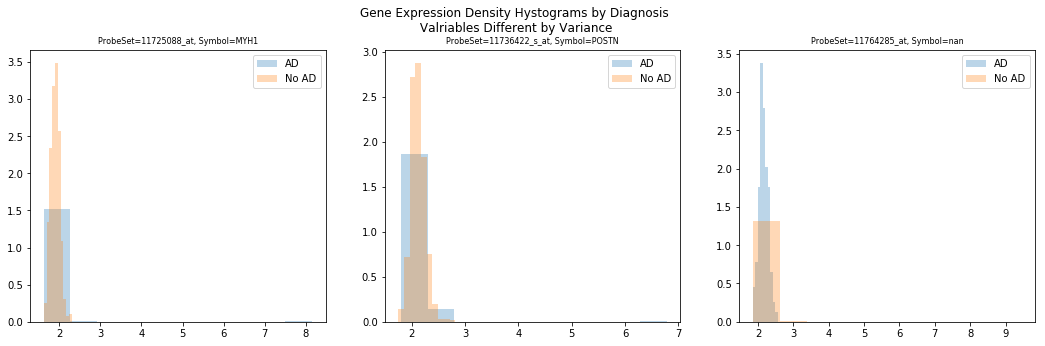

In [93]:
fig, axs = plt.subplots(1,3, figsize = (18,5))
fig.suptitle('Gene Expression Density Hystograms by Diagnosis \n Valriables Different by Variance ', y = 1)
for i, ax in enumerate(axs.ravel()):
    ax.hist(pat_genes1[pat_genes1['AD_any']][std_change.index[i]], alpha = 0.3, density = True, label = 'AD')
    ax.hist(pat_genes1[pat_genes1['AD_any']==False][std_change.index[i]], alpha = 0.3, density = True, label = 'No AD')
    ax.set_title('ProbeSet={}, Symbol={}'.format(std_change['ProbeSet'][i],
                std_change['Symbol'][i]), fontsize = 8)
    ax.legend()